# Implementation of WGAN-GP
Reference: https://arxiv.org/pdf/1704.00028.pdf


In [ ]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

In [3]:
import numpy as np
import datetime
import os, sys

In [4]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [5]:
MODEL_NAME = 'WGAN-gp'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [7]:
def get_sample_image(G, n_noise=100):
    """
        save sample 100 images
    """
    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z,c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

In [8]:
class Discriminator(nn.Module):
    """
        Convolutional Discriminator for MNIST
    """
    def __init__(self, in_channel=1, input_size=784, condition_size=10, num_classes=1):
        super(Discriminator, self).__init__()
        self.transform = nn.Sequential(
            nn.Linear(input_size+condition_size, 784),
            nn.LeakyReLU(0.2),
        )
        self.conv = nn.Sequential(
            # 28 -> 14
            nn.Conv2d(in_channel, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            # 14 -> 7
            nn.Conv2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            # 7 -> 4
            nn.Conv2d(256, 128, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(4),
        )
        self.fc = nn.Sequential(
            # reshape input, 128 -> 1
            nn.Linear(128, 1),
        )
    
    def forward(self, x, c=None):
        # x: (N, 1, 28, 28), c: (N, 10)
        x, c = x.view(x.size(0), -1), c.float() # may not need
        v = torch.cat((x, c), 1) # v: (N, 794)
        y_ = self.transform(v) # (N, 784)
        y_ = y_.view(y_.shape[0], 1, 28, 28) # (N, 1, 28, 28)
        y_ = self.conv(y_)
        y_ = y_.view(y_.size(0), -1)
        y_ = self.fc(y_)
        return y_

In [9]:
class Generator(nn.Module):
    """
        Convolutional Generator for MNIST
    """
    def __init__(self, input_size=100, condition_size=10):
        super(Generator, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size+condition_size, 4*4*512),
            nn.ReLU(),
        )
        self.conv = nn.Sequential(
            # input: 4 by 4, output: 7 by 7
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            # input: 7 by 7, output: 14 by 14
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            # input: 14 by 14, output: 28 by 28
            nn.ConvTranspose2d(128, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )
        
    def forward(self, x, c):
        # x: (N, 100), c: (N, 10)
        x, c = x.view(x.size(0), -1), c.float() # may not need
        v = torch.cat((x, c), 1) # v: (N, 110)
        y_ = self.fc(v)
        y_ = y_.view(y_.size(0), 512, 4, 4)
        y_ = self.conv(y_) # (N, 28, 28)
        return y_

In [10]:
D = Discriminator().to(DEVICE)
G = Generator().to(DEVICE)
# D.load_state_dict('D_dc.pkl')
# G.load_state_dict('G_dc.pkl')

In [11]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))]
)

In [12]:
mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

In [13]:
batch_size = 64

In [14]:
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

In [15]:
D_opt = torch.optim.Adam(D.parameters(), lr=0.0005, betas=(0.5, 0.9))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0005, betas=(0.5, 0.9))

In [16]:
max_epoch = 30 # need more than 20 epochs for training generator
step = 0
n_noise = 100
p_coeff = 10 # lambda
n_critic = 5

In [17]:
D_labels = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label to fake

In [18]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(data_loader):
        D.zero_grad()
        ## Training Discriminator
        # Real data
        x = images.to(DEVICE)
        y = labels.view(batch_size, 1)
        y = to_onehot(y).to(DEVICE)
        
        # Sampling
        z = torch.randn(batch_size, n_noise).to(DEVICE)
        x_fake = G(z, y)
                
        # Gradient Penalty (e.g. gradients w.r.t x_penalty)
        eps = torch.rand(batch_size, 1, 1, 1).to(DEVICE) # x shape: (64, 1, 28, 28)
        x_penalty = eps*x + (1-eps)*x_fake
        x_penalty = x_penalty.view(x_penalty.size(0), -1)
        p_outputs = D(x_penalty, y)
        xp_grad = autograd.grad(outputs=p_outputs, inputs=x_penalty, grad_outputs=D_labels,
                                create_graph=True, retain_graph=True, only_inputs=True)
        grad_penalty = p_coeff * torch.mean(torch.pow(torch.norm(xp_grad[0], 2, 1) - 1, 2))
        
        # Wasserstein loss
        x_outputs = D(x, y)
        z_outputs = D(x_fake, y)
        D_x_loss = torch.mean(x_outputs)
        D_z_loss = torch.mean(z_outputs)
        D_loss = D_z_loss - D_x_loss + grad_penalty
        
        D_loss.backward()
        D_opt.step()        
        if step % n_critic == 0:
            D.zero_grad()
            G.zero_grad()
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z, y), y)
            G_loss = -torch.mean(z_outputs)

            G_loss.backward()
            G_opt.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/30, Step: 0, D Loss: 9.205890655517578, G Loss: -0.027526430785655975
Epoch: 0/30, Step: 500, D Loss: -6.2204813957214355, G Loss: 2.9368131160736084
Epoch: 1/30, Step: 1000, D Loss: -5.232357978820801, G Loss: 3.1163578033447266
Epoch: 1/30, Step: 1500, D Loss: -4.480729579925537, G Loss: 4.4438371658325195
Epoch: 2/30, Step: 2000, D Loss: -4.630670547485352, G Loss: 4.495148658752441
Epoch: 2/30, Step: 2500, D Loss: -4.7737579345703125, G Loss: 4.519621849060059
Epoch: 3/30, Step: 3000, D Loss: -2.872873306274414, G Loss: 5.068078994750977
Epoch: 3/30, Step: 3500, D Loss: -3.017317533493042, G Loss: 4.754785537719727
Epoch: 4/30, Step: 4000, D Loss: -4.193995952606201, G Loss: 5.679494857788086
Epoch: 4/30, Step: 4500, D Loss: -2.3448548316955566, G Loss: 5.901308536529541
Epoch: 5/30, Step: 5000, D Loss: -2.5334980487823486, G Loss: 4.977435111999512
Epoch: 5/30, Step: 5500, D Loss: -2.479895830154419, G Loss: 5.950960159301758
Epoch: 6/30, Step: 6000, D Loss: -3.2865302562

## Sample

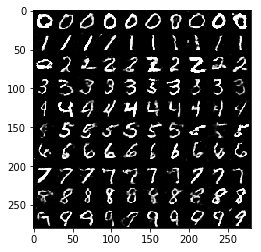

In [19]:
# generation to image
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [15]:
def save_checkpoint(state, file_name='checkpoint.pth.tar'):
    torch.save(state, file_name)

In [16]:
# Saving params.
# torch.save(D.state_dict(), 'D_c.pkl')
# torch.save(G.state_dict(), 'G_c.pkl')
save_checkpoint({'epoch': epoch + 1, 'state_dict':D.state_dict(), 'optimizer' : D_opt.state_dict()}, 'D_gp.pth.tar')
save_checkpoint({'epoch': epoch + 1, 'state_dict':G.state_dict(), 'optimizer' : G_opt.state_dict()}, 'G_gp.pth.tar')